# Chapter 3
## Classification

### MNIST

In [1]:
from sklearn.datasets import fetch_openml

# Example: Fetch MNIST dataset
mnist = fetch_openml('mnist_784', version=1)


c:\Users\acer\Desktop\HandsOnML\myenv\Lib\site-packages\sklearn\datasets\_openml.py:72: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)


MemoryError: Unable to allocate 8.00 KiB for an array with shape (1024,) and data type int64

In [7]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

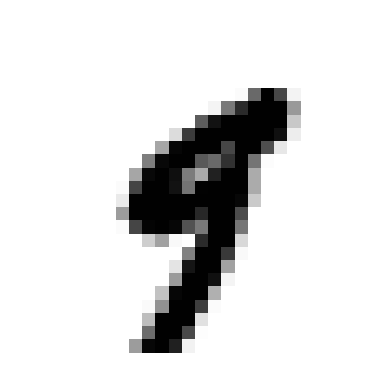

In [8]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

X = np.array(X)
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
 interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
#train and test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
#shuffle the train set to ensure all folds contain all digits
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

In [11]:
y = y.astype(np.int8)
y_train_5 = (y_train == '5') # True for all 5s, False for all other digits.
y_test_5 = (y_test == '5')
y_train_5

40661    False
40118    False
46489     True
19439    False
10342    False
         ...  
44720    False
59821    False
51250    False
16369    False
53464    False
Name: class, Length: 60000, dtype: bool

In [12]:
#training using stochastic gradient descent (SGD)
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [13]:
sgd_clf.predict([X_train[20000]])

array([False])

In [14]:
#using cross val to check the accuracy
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9467, 0.9516, 0.9693])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for train_index, test_index in skfolds.split(X_train, y_train_5):
 clone_clf = clone(sgd_clf)
 X_train_folds = X_train[train_index]
 y_train_folds = (y_train_5[train_index])
 X_test_fold = X_train[test_index]
 y_test_fold = (y_train_5[test_index])
 clone_clf.fit(X_train_folds, y_train_folds)
 y_pred = clone_clf.predict(X_test_fold)
 n_correct = sum(y_pred == y_test_fold)
 print(n_correct / len(y_pred)) # prints 0.9502, 0.96565 and 0.96495

0.695
0.86865
0.66135


### confusion matrix

In [16]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[54321,   258],
       [ 2390,  3031]])

### precision and recall

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4344 / (4344 + 1307)
recall_score(y_train_5, y_train_pred)

np.float64(0.5591219332226527)

In [19]:
#f1 score, harmonic mean of precision and recall
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

np.float64(0.6959816303099885)

In [20]:
### tradeoff using threshold value
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-3517.44816041])

In [21]:
threshold = -5000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
 method="decision_function")

In [24]:
#precision recall curve
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
 plt.xlabel("Threshold")
 plt.legend(loc="upper left")
 plt.ylim([0, 1])

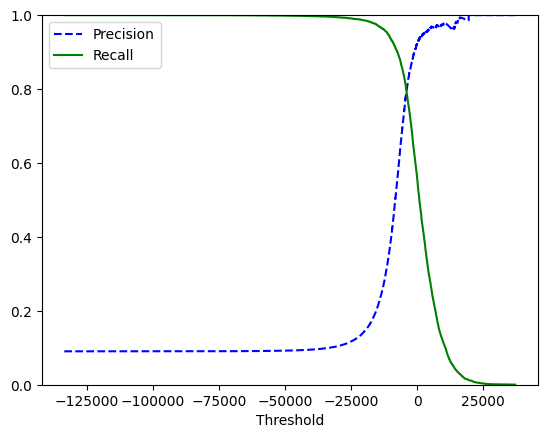

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### ROC curve

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [28]:
def plot_roc_curve(fpr, tpr, label=None):
 plt.plot(fpr, tpr, linewidth=2, label=label)
 plt.plot([0, 1], [0, 1], 'k--')
 plt.axis([0, 1, 0, 1])
 plt.xlabel('False Positive Rate')
 plt.ylabel('True Positive Rate')

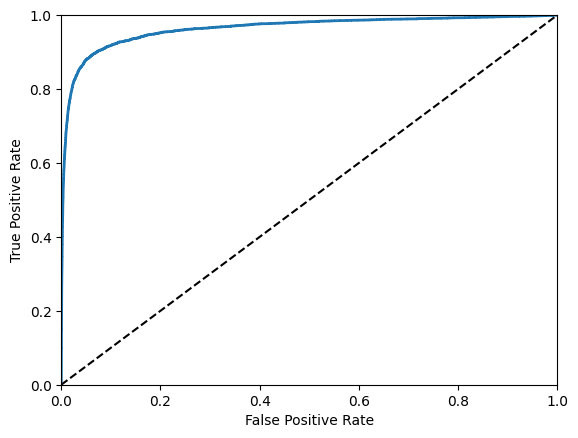

In [29]:
plot_roc_curve(fpr, tpr)
plt.show()

In [30]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

np.float64(0.9633483797675337)

### ROC for randomForestClassifier

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
 method="predict_proba")

In [32]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

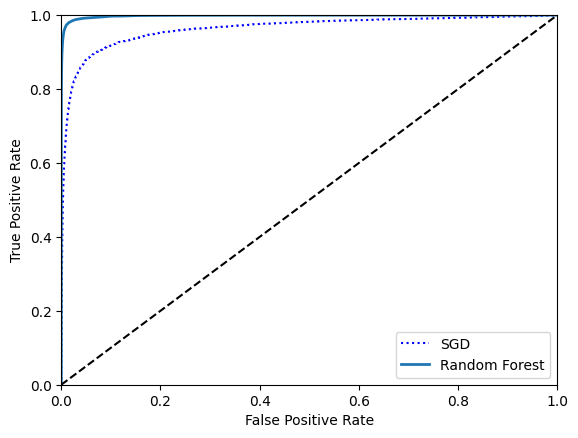

In [33]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9982848336504003)

## MultiClass Classification

# Exercises

In [35]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

In [36]:
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [52]:
from sklearn.model_selection import GridSearchCV
params = [
    {"weights":['uniform', 'distance'], "n_neighbors":[1., 3., 5., 10., 15.]}
]
grid_search = GridSearchCV(knn_clf, params, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=4)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


MemoryError: Unable to allocate 287. MiB for an array with shape (48000, 784) and data type int64